## Import some python packages

In [1]:
%matplotlib inline
import pickle
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.models import load_model  # For loading the trained model
from tensorflow.keras.layers import Reshape, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Load the data

In [2]:
Xd = pickle.load(open("data/RML2016.10a_dict.pkl",'rb'),encoding = "bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

## Split the data into training and test sets

In [3]:
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2

train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))

X_train = X[train_idx]
X_test = X[test_idx]

## Convert the dependent variables (labels) into one-hoe encoding format

In [4]:
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)

lbl_encoded = lb.transform(np.asarray(lbl)[:,0])
y_train = lbl_encoded[train_idx]
y_test = lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [5]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


## Build all the PCA models used in this module

In [6]:
total_components = in_shp[0] * in_shp[1]

In [7]:
# PCA model that extracts 1/4 components, reduces the dimension by 75%
pca_1 = PCA(n_components = total_components // 4)

In [8]:
# PCA model that extracts 3/8 components, reduces the dimension by 62.5%
pca_2 = PCA(n_components = 3 * total_components // 8)

In [9]:
# PCA model that extracts 1/2 components, reduces the dimension by 50%
pca_3 = PCA(n_components = total_components // 2)

In [10]:
# PCA model that extracts 3/4 components, reduces the dimension by 25%
pca_4 = PCA(n_components = 3 * total_components // 4)

## Get all the low-dimensional inputs ready

In [11]:
# PCA model only accepts 2D or 1D data, the original data should be flatting from 3D to 2D first
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

In [12]:
X_train_1 = pca_1.fit_transform(X_train_flat)

In [13]:
X_train_2 = pca_2.fit_transform(X_train_flat)

In [14]:
X_train_3 = pca_3.fit_transform(X_train_flat)

In [15]:
X_train_4 = pca_4.fit_transform(X_train_flat)

In [16]:
X_test_1 = pca_1.fit_transform(X_test_flat)

In [17]:
X_test_2 = pca_2.fit_transform(X_test_flat)

In [18]:
X_test_3 = pca_3.fit_transform(X_test_flat)

In [19]:
X_test_4 = pca_4.fit_transform(X_test_flat)

## Restore the data to 3-dimension

In [20]:
X_train_1 = X_train_1.reshape(X_train_1.shape[0], 2, -1)
X_train_2 = X_train_2.reshape(X_train_2.shape[0], 2, -1)
X_train_3 = X_train_3.reshape(X_train_3.shape[0], 2, -1)
X_train_4 = X_train_4.reshape(X_train_4.shape[0], 2, -1)

In [21]:
X_test_1 = X_test_1.reshape(X_test_1.shape[0], 2, -1)
X_test_2 = X_test_2.reshape(X_test_2.shape[0], 2, -1)
X_test_3 = X_test_3.reshape(X_test_3.shape[0], 2, -1)
X_test_4 = X_test_4.reshape(X_test_4.shape[0], 2, -1)

## Get the `in_shp` variable ready for building the CNN models

In [22]:
in_shp_1 = list(X_train_1.shape[1:])
in_shp_2 = list(X_train_2.shape[1:])
in_shp_3 = list(X_train_3.shape[1:])
in_shp_4 = list(X_train_4.shape[1:])

## Load the CNN models used in this module

In [23]:
model_1 = load_model('model/CNN_model_1.h5')

In [24]:
model_2 = load_model('model/CNN_model_2.h5')

In [25]:
model_3 = load_model('model/CNN_model_3.h5')

In [26]:
model_4 = load_model('model/CNN_model_4.h5')

In [27]:
model_5 = load_model('model/CNN_model_5.h5')

## Build all the CNN models

#### If you have already loaded the model in the `Load the CNN models used in this module` section, please feel free to skip this step

In [28]:
def build_CNN_model(in_shp):
    model_CNN = models.Sequential()

    model_CNN.add(Reshape(in_shp + [1], input_shape = in_shp))

    model_CNN.add(Conv2D(64, (1, 16), activation ='relu'))
    model_CNN.add(Dropout(0.5))

    model_CNN.add(Conv2D(32, (2, 8), activation ='relu'))
    model_CNN.add(Dropout(0.5))

    model_CNN.add(Conv2D(16, (1, 4), activation ='relu'))
    model_CNN.add(Dropout(0.5))

    model_CNN.add(Flatten())

    model_CNN.add(Dense(512, activation ='relu'))
    model_CNN.add(Dropout(0.5))

    model_CNN.add(Dense(128, activation ='relu'))
    model_CNN.add(Dropout(0.5))

    model_CNN.add(Dense(len(classes), activation ='softmax'))
    
    return model_CNN

In [29]:
model_1 = build_CNN_model(in_shp_1)
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 2, 32, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 17, 64)         1088      
_________________________________________________________________
dropout (Dropout)            (None, 2, 17, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 10, 32)         32800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 10, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 7, 16)          2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 7, 16)          0

In [30]:
model_2 = build_CNN_model(in_shp_2)
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 48, 1)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 33, 64)         1088      
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 33, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 26, 32)         32800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 26, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 23, 16)         2064      
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 23, 16)        

In [31]:
model_3 = build_CNN_model(in_shp_3)
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 2, 64, 1)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 49, 64)         1088      
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 49, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 42, 32)         32800     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1, 42, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 39, 16)         2064      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 39, 16)        

In [32]:
model_4 = build_CNN_model(in_shp_4)
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 2, 96, 1)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 81, 64)         1088      
_________________________________________________________________
dropout_15 (Dropout)         (None, 2, 81, 64)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 74, 32)         32800     
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 74, 32)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 71, 16)         2064      
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 71, 16)        

In [33]:
model_5 = build_CNN_model(in_shp)
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 113, 64)        1088      
_________________________________________________________________
dropout_20 (Dropout)         (None, 2, 113, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 106, 32)        32800     
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 106, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 103, 16)        2064      
_________________________________________________________________
dropout_22 (Dropout)         (None, 1, 103, 16)       

## Compile all the CNN models

#### If you have already loaded the model in the `Load the CNN models used in this module` section, please feel free to skip this step

In [34]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [35]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [36]:
model_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [37]:
model_4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [38]:
model_5.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Train all the CNN models

#### If you have already loaded the model in the `Load the CNN models used in this module` section, please feel free to skip this step

In [39]:
tic_1 = time.time()
history_1 = model_1.fit(X_train_1, y_train, batch_size = 1024, epochs = 100, verbose = 1, 
                        validation_data = (X_test_1, y_test),
                        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, 
                                                   verbose = 1, mode = 'auto', 
                                                   restore_best_weights = True)])
toc_1 = time.time()

Epoch 1/100
108/108 [==============================] - 29s 249ms/step - loss: 2.3130 - accuracy: 0.1278 - val_loss: 2.0339 - val_accuracy: 0.2173
Epoch 2/100
108/108 [==============================] - 22s 199ms/step - loss: 2.0455 - accuracy: 0.2192 - val_loss: 1.9201 - val_accuracy: 0.2740
Epoch 3/100
108/108 [==============================] - 22s 200ms/step - loss: 1.9403 - accuracy: 0.2616 - val_loss: 1.8805 - val_accuracy: 0.2893
Epoch 4/100
108/108 [==============================] - 22s 202ms/step - loss: 1.9046 - accuracy: 0.2702 - val_loss: 1.8972 - val_accuracy: 0.2880
Epoch 5/100
108/108 [==============================] - 22s 200ms/step - loss: 1.8898 - accuracy: 0.2826 - val_loss: 1.8550 - val_accuracy: 0.2966
Epoch 6/100
108/108 [==============================] - 22s 201ms/step - loss: 1.8766 - accuracy: 0.2856 - val_loss: 1.8439 - val_accuracy: 0.3011
Epoch 7/100
108/108 [==============================] - 22s 202ms/step - loss: 1.8658 - accuracy: 0.2914 - val_loss: 1.8295 -

In [40]:
tic_2 = time.time()
history_2 = model_2.fit(X_train_2, y_train, batch_size = 1024, epochs = 100, verbose = 1, 
                        validation_data = (X_test_2, y_test),
                        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, 
                                                   verbose = 1, mode = 'auto', 
                                                   restore_best_weights = True)])
toc_2 = time.time()

Epoch 1/100
108/108 [==============================] - 43s 393ms/step - loss: 2.3418 - accuracy: 0.1140 - val_loss: 1.9588 - val_accuracy: 0.2613
Epoch 2/100
108/108 [==============================] - 42s 386ms/step - loss: 1.9464 - accuracy: 0.2607 - val_loss: 1.8456 - val_accuracy: 0.2962
Epoch 3/100
108/108 [==============================] - 44s 411ms/step - loss: 1.8740 - accuracy: 0.2852 - val_loss: 1.8146 - val_accuracy: 0.3082
Epoch 4/100
108/108 [==============================] - 42s 386ms/step - loss: 1.8521 - accuracy: 0.2957 - val_loss: 1.8003 - val_accuracy: 0.3173
Epoch 5/100
108/108 [==============================] - 41s 384ms/step - loss: 1.8305 - accuracy: 0.3072 - val_loss: 1.7957 - val_accuracy: 0.3155
Epoch 6/100
108/108 [==============================] - 42s 385ms/step - loss: 1.8200 - accuracy: 0.3110 - val_loss: 1.7708 - val_accuracy: 0.3279
Epoch 7/100
108/108 [==============================] - 42s 386ms/step - loss: 1.8096 - accuracy: 0.3170 - val_loss: 1.7657 -

In [41]:
tic_3 = time.time()
history_3 = model_3.fit(X_train_3, y_train, batch_size = 1024, epochs = 100, verbose = 1, 
                        validation_data = (X_test_3, y_test),
                        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, 
                                                   verbose = 1, mode = 'auto', 
                                                   restore_best_weights = True)])
toc_3 = time.time()

Epoch 1/100
108/108 [==============================] - 66s 597ms/step - loss: 2.3002 - accuracy: 0.1398 - val_loss: 1.8659 - val_accuracy: 0.2990
Epoch 2/100
108/108 [==============================] - 64s 597ms/step - loss: 1.9128 - accuracy: 0.2743 - val_loss: 1.8152 - val_accuracy: 0.3194
Epoch 3/100
108/108 [==============================] - 63s 588ms/step - loss: 1.8538 - accuracy: 0.2972 - val_loss: 1.7787 - val_accuracy: 0.3303
Epoch 4/100
108/108 [==============================] - 64s 589ms/step - loss: 1.8244 - accuracy: 0.3061 - val_loss: 1.7660 - val_accuracy: 0.3373
Epoch 5/100
108/108 [==============================] - 64s 591ms/step - loss: 1.8159 - accuracy: 0.3154 - val_loss: 1.7526 - val_accuracy: 0.3395
Epoch 6/100
108/108 [==============================] - 63s 588ms/step - loss: 1.7996 - accuracy: 0.3212 - val_loss: 1.7424 - val_accuracy: 0.3461
Epoch 7/100
108/108 [==============================] - 64s 591ms/step - loss: 1.7920 - accuracy: 0.3227 - val_loss: 1.7682 -

In [42]:
tic_4 = time.time()
history_4 = model_4.fit(X_train_4, y_train, batch_size = 1024, epochs = 100, verbose = 1, 
                        validation_data = (X_test_4, y_test),
                        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, 
                                                   verbose = 1, mode = 'auto', 
                                                   restore_best_weights = True)])
toc_4 = time.time()

Epoch 1/100
108/108 [==============================] - 106s 966ms/step - loss: 2.3582 - accuracy: 0.1120 - val_loss: 1.9117 - val_accuracy: 0.2716
Epoch 2/100
108/108 [==============================] - 105s 977ms/step - loss: 1.9385 - accuracy: 0.2638 - val_loss: 1.8161 - val_accuracy: 0.3183
Epoch 3/100
108/108 [==============================] - 104s 959ms/step - loss: 1.8614 - accuracy: 0.2928 - val_loss: 1.7933 - val_accuracy: 0.3273
Epoch 4/100
108/108 [==============================] - 104s 963ms/step - loss: 1.8321 - accuracy: 0.3055 - val_loss: 1.7709 - val_accuracy: 0.3286
Epoch 5/100
108/108 [==============================] - 104s 964ms/step - loss: 1.8112 - accuracy: 0.3127 - val_loss: 1.7527 - val_accuracy: 0.3376
Epoch 6/100
108/108 [==============================] - 104s 966ms/step - loss: 1.7996 - accuracy: 0.3139 - val_loss: 1.7492 - val_accuracy: 0.3422
Epoch 7/100
108/108 [==============================] - 103s 957ms/step - loss: 1.7968 - accuracy: 0.3203 - val_loss: 1

In [43]:
tic_5 = time.time()
history_5 = model_5.fit(X_train, y_train, batch_size = 1024, epochs = 100, verbose = 1, 
                        validation_data = (X_test, y_test),
                        callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10, 
                                                   verbose = 1, mode = 'auto', 
                                                   restore_best_weights = True)])
toc_5 = time.time()

Epoch 1/100
108/108 [==============================] - 146s 1s/step - loss: 2.3480 - accuracy: 0.1167 - val_loss: 2.0251 - val_accuracy: 0.2440
Epoch 2/100
108/108 [==============================] - 147s 1s/step - loss: 2.0042 - accuracy: 0.2382 - val_loss: 1.7876 - val_accuracy: 0.3283
Epoch 3/100
108/108 [==============================] - 150s 1s/step - loss: 1.7357 - accuracy: 0.3371 - val_loss: 1.5807 - val_accuracy: 0.3857
Epoch 4/100
108/108 [==============================] - 148s 1s/step - loss: 1.5904 - accuracy: 0.3815 - val_loss: 1.4903 - val_accuracy: 0.4146
Epoch 5/100
108/108 [==============================] - 144s 1s/step - loss: 1.5301 - accuracy: 0.4039 - val_loss: 1.4137 - val_accuracy: 0.4660
Epoch 6/100
108/108 [==============================] - 147s 1s/step - loss: 1.4629 - accuracy: 0.4396 - val_loss: 1.3851 - val_accuracy: 0.4749
Epoch 7/100
108/108 [==============================] - 152s 1s/step - loss: 1.4048 - accuracy: 0.4622 - val_loss: 1.3310 - val_accuracy:

## Save all the trained CNN models

#### If you have already loaded the model in the `Load the CNN models used in this module` section, please feel free to skip this step

In [44]:
model_1.save('model/CNN_model_1.h5')

In [45]:
model_2.save('model/CNN_model_2.h5')

In [46]:
model_3.save('model/CNN_model_3.h5')

In [47]:
model_4.save('model/CNN_model_4.h5')

In [48]:
model_5.save('model/CNN_model_5.h5')

## Compare the training time

#### If you have not trained the models, you may not get the reuslt in this section

In [84]:
training_time_1 = toc_1 - tic_1
training_time_2 = toc_2 - tic_2
training_time_3 = toc_3 - tic_3
training_time_4 = toc_4 - tic_4
training_time_5 = toc_5 - tic_5

print ("The training time for CNN with 75%% dimensionality reduction is %.3f seconds" %(training_time_1))
print ("The training time for CNN with 62.5%% dimensionality reduction is %.3f seconds" %(training_time_2))
print ("The training time for CNN with 50%% dimensionality reduction is %.3f seconds" %(training_time_3))
print ("The training time for CNN with 25%% dimensionality reduction is %.3f seconds" %(training_time_4))
print ("The training time for CNN without dimensionality reduction is %.3f seconds" %(training_time_5))

The training time for CNN with 75% dimensionality reduction is 727.873 seconds
The training time for CNN with 62.5% dimensionality reduction is 1992.885 seconds
The training time for CNN with 50% dimensionality reduction is 2868.902 seconds
The training time for CNN with 25% dimensionality reduction is 7646.649 seconds
The training time for CNN without dimensionality reduction is 10880.318 seconds


## Compare test loss and accuracy

In [51]:
score_1 = model_1.evaluate(X_test_1, y_test)

3438/3438 [==============================] - 8s 2ms/step - loss: 1.7058 - accuracy: 0.3585


In [52]:
score_2 = model_2.evaluate(X_test_2, y_test)

3438/3438 [==============================] - 14s 4ms/step - loss: 1.6263 - accuracy: 0.3903


In [53]:
score_3 = model_3.evaluate(X_test_3, y_test)

3438/3438 [==============================] - 21s 6ms/step - loss: 1.5968 - accuracy: 0.4041


In [54]:
score_4 = model_4.evaluate(X_test_4, y_test)

3438/3438 [==============================] - 26s 7ms/step - loss: 1.6258 - accuracy: 0.3941


In [55]:
score_5 = model_5.evaluate(X_test, y_test)

3438/3438 [==============================] - 32s 9ms/step - loss: 1.1498 - accuracy: 0.5545


In [85]:
print('Test loss of CNN with 75% dimensionality reduction:', score_1[0])
print('Test accuracy of CNN with 75% dimensionality reduction:', score_1[1])
print()
print('Test loss of CNN with 62.5% dimensionality reduction:', score_2[0])
print('Test accuracy of CNN with 62.5% dimensionality reduction:', score_2[1])
print()
print('Test loss of CNN with 50% dimensionality reduction:', score_3[0])
print('Test accuracy of CNN with 50% dimensionality reduction:', score_3[1])
print()
print('Test loss of CNN with 25% dimensionality reduction:', score_4[0])
print('Test accuracy of CNN with 25% dimensionality reduction:', score_4[1])
print()
print('Test loss of CNN without dimensionality reduction:', score_5[0])
print('Test accuracy of CNN without dimensionality reduction:', score_5[1])

Test loss of CNN with 75% dimensionality reduction: 1.7057504653930664
Test accuracy of CNN with 75% dimensionality reduction: 0.35850000381469727

Test loss of CNN with 62.5% dimensionality reduction: 1.6262885332107544
Test accuracy of CNN with 62.5% dimensionality reduction: 0.39029091596603394

Test loss of CNN with 50% dimensionality reduction: 1.5967787504196167
Test accuracy of CNN with 50% dimensionality reduction: 0.40410909056663513

Test loss of CNN with 25% dimensionality reduction: 1.6258200407028198
Test accuracy of CNN with 25% dimensionality reduction: 0.3941272795200348

Test loss of CNN without dimensionality reduction: 1.1498254537582397
Test accuracy of CNN without dimensionality reduction: 0.5545272827148438


## Show classification report

In [86]:
y_predict_1 = model_1.predict(X_test_1)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_1, axis = 1)))

              precision    recall  f1-score   support

           0       0.14      0.00      0.00      9991
           1       0.55      0.70      0.62     10041
           2       0.25      0.99      0.40      9915
           3       0.27      0.02      0.03      9841
           4       0.39      0.56      0.46     10076
           5       0.82      0.61      0.70     10067
           6       0.58      0.31      0.40     10086
           7       0.00      0.00      0.00     10024
           8       0.24      0.57      0.34      9920
           9       0.18      0.09      0.12      9998
          10       0.79      0.10      0.17     10041

    accuracy                           0.36    110000
   macro avg       0.38      0.36      0.30    110000
weighted avg       0.38      0.36      0.30    110000



In [87]:
y_predict_2 = model_2.predict(X_test_2)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_2, axis = 1)))

              precision    recall  f1-score   support

           0       0.23      0.19      0.21      9991
           1       0.55      0.70      0.61     10041
           2       0.26      0.97      0.41      9915
           3       0.34      0.09      0.14      9841
           4       0.47      0.56      0.51     10076
           5       0.81      0.63      0.71     10067
           6       0.59      0.44      0.50     10086
           7       0.21      0.11      0.15     10024
           8       0.31      0.44      0.36      9920
           9       0.38      0.04      0.07      9998
          10       0.76      0.13      0.22     10041

    accuracy                           0.39    110000
   macro avg       0.45      0.39      0.35    110000
weighted avg       0.45      0.39      0.35    110000



In [88]:
y_predict_3 = model_3.predict(X_test_3)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_3, axis = 1)))

              precision    recall  f1-score   support

           0       0.21      0.09      0.13      9991
           1       0.56      0.70      0.62     10041
           2       0.25      0.98      0.40      9915
           3       0.32      0.16      0.21      9841
           4       0.51      0.55      0.53     10076
           5       0.84      0.62      0.72     10067
           6       0.64      0.50      0.56     10086
           7       0.13      0.00      0.01     10024
           8       0.32      0.52      0.39      9920
           9       0.33      0.19      0.24      9998
          10       0.81      0.14      0.24     10041

    accuracy                           0.40    110000
   macro avg       0.45      0.40      0.37    110000
weighted avg       0.45      0.40      0.37    110000



In [89]:
y_predict_4 = model_4.predict(X_test_4)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_4, axis = 1)))

              precision    recall  f1-score   support

           0       0.17      0.03      0.05      9991
           1       0.56      0.70      0.62     10041
           2       0.26      0.97      0.41      9915
           3       0.33      0.16      0.21      9841
           4       0.45      0.58      0.51     10076
           5       0.80      0.63      0.71     10067
           6       0.71      0.36      0.48     10086
           7       0.24      0.21      0.22     10024
           8       0.34      0.30      0.32      9920
           9       0.30      0.25      0.27      9998
          10       0.86      0.14      0.24     10041

    accuracy                           0.39    110000
   macro avg       0.46      0.39      0.37    110000
weighted avg       0.46      0.39      0.37    110000



In [90]:
y_predict_5 = model_5.predict(X_test)
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_predict_5, axis = 1)))

              precision    recall  f1-score   support

           0       0.79      0.53      0.63      9991
           1       0.51      0.64      0.57     10041
           2       0.26      0.95      0.41      9915
           3       0.88      0.59      0.70      9841
           4       0.80      0.64      0.71     10076
           5       0.82      0.64      0.72     10067
           6       0.88      0.69      0.77     10086
           7       0.47      0.33      0.39     10024
           8       0.53      0.45      0.49      9920
           9       0.81      0.54      0.65      9998
          10       0.56      0.11      0.19     10041

    accuracy                           0.55    110000
   macro avg       0.66      0.55      0.57    110000
weighted avg       0.66      0.55      0.57    110000



## Show loss curves 

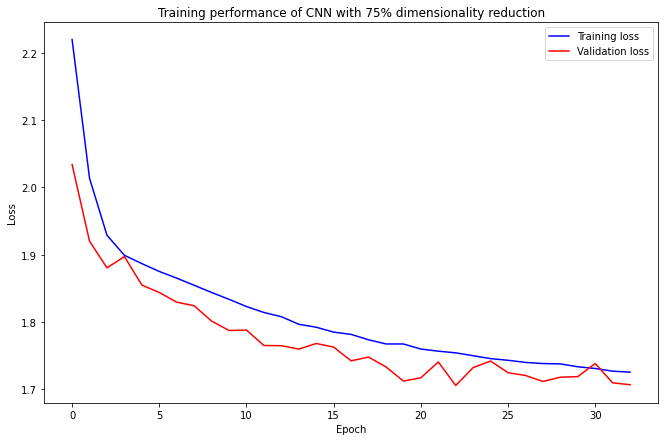

In [91]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of CNN with 75% dimensionality reduction')
plt.plot(history_1.epoch, history_1.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_1.epoch, history_1.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/CNN_loss_curve_1.png')
plt.show()

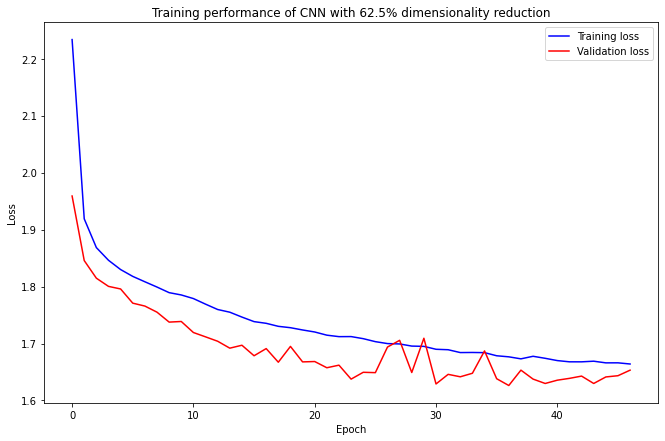

In [92]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of CNN with 62.5% dimensionality reduction')
plt.plot(history_2.epoch, history_2.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_2.epoch, history_2.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/CNN_loss_curve_2.png')
plt.show()

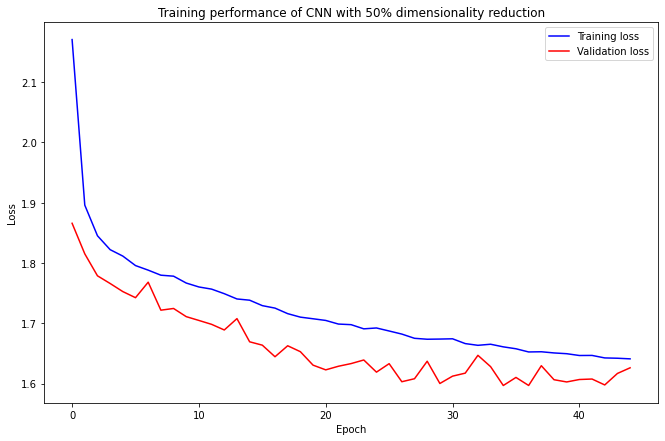

In [93]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of CNN with 50% dimensionality reduction')
plt.plot(history_3.epoch, history_3.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_3.epoch, history_3.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/CNN_loss_curve_3.png')
plt.show()

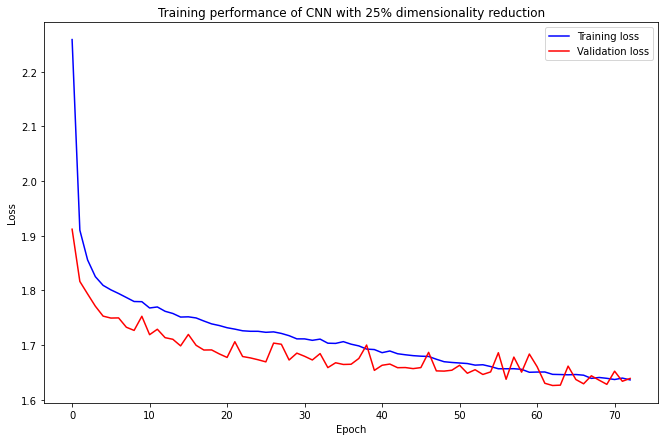

In [94]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of CNN with 25% dimensionality reduction')
plt.plot(history_4.epoch, history_4.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_4.epoch, history_4.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/CNN_loss_curve_4.png')
plt.show()

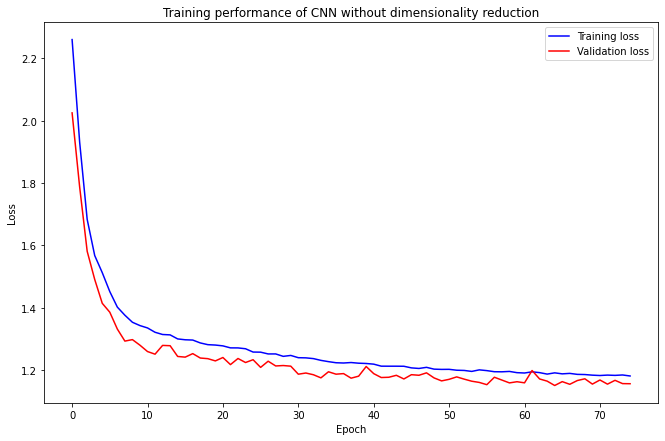

In [95]:
plt.figure(figsize = (11, 7))
plt.title('Training performance of CNN without dimensionality reduction')
plt.plot(history_5.epoch, history_5.history['loss'], color = 'blue', label = 'Training loss')
plt.plot(history_5.epoch, history_5.history['val_loss'], color = 'red', label = 'Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('img/CNN_loss_curve_5.png')
plt.show()

## Plot confusion matrix

In [96]:
def plot_confusion_matrix(cm, title, cmap = plt.cm.Blues, labels = []):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation = 45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [97]:
def confusion_matrix(model, classes, X_test, y_test, title):
    test_Y_hat = model.predict(X_test, batch_size = 1024)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])

    for i in range(0, X_test.shape[0]):
        j = list(y_test[i,:]).index(1)
        k = int(np.argmax(test_Y_hat[i,:]))
        conf[j,k] = conf[j,k] + 1

    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    plot_confusion_matrix(confnorm, title, labels = classes)

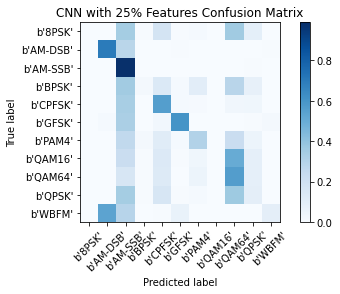

In [98]:
confusion_matrix(model_1, classes, X_test_1, y_test, 'CNN with 25% Features Confusion Matrix')

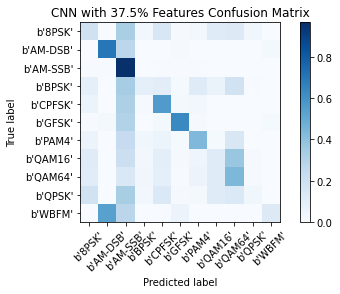

In [99]:
confusion_matrix(model_2, classes, X_test_2, y_test, 'CNN with 37.5% Features Confusion Matrix')

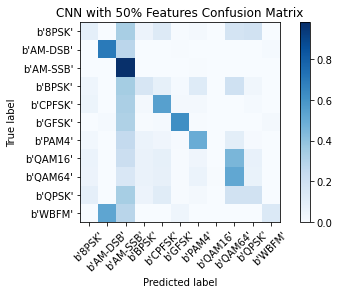

In [100]:
confusion_matrix(model_3, classes, X_test_3, y_test, 'CNN with 50% Features Confusion Matrix')

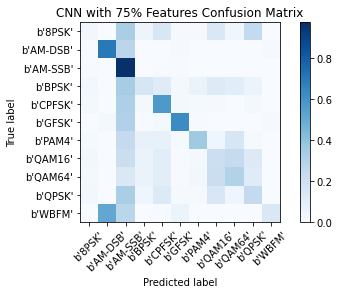

In [101]:
confusion_matrix(model_4, classes, X_test_4, y_test, 'CNN with 75% Features Confusion Matrix')

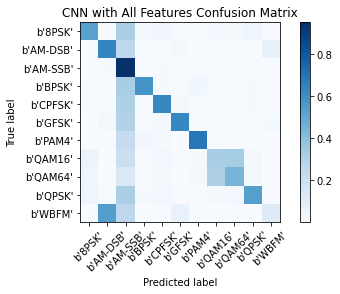

In [102]:
confusion_matrix(model_5, classes, X_test, y_test, 'CNN with All Features Confusion Matrix')

## Get the test accuracy for different SNRs

In [103]:
def getTestAccArray(model, lbl, X_test, y_test, test_idx, model_name):
    acc = []
    
    snr_array=np.asarray(lbl)[:,1]
    lb_temp = preprocessing.LabelBinarizer()
    lb_temp.fit(snr_array)
    temp_array=lb_temp.classes_
    snr_label_array = []
    test_SNRs=snr_array[test_idx]

    snr_label_array.append(temp_array[6])
    snr_label_array.append(temp_array[4])
    snr_label_array.append(temp_array[3])
    snr_label_array.append(temp_array[2])
    snr_label_array.append(temp_array[1])
    snr_label_array.append(temp_array[0])
    snr_label_array.append(temp_array[9])
    snr_label_array.append(temp_array[8])
    snr_label_array.append(temp_array[7])
    snr_label_array.append(temp_array[5])
    snr_label_array.append(temp_array[10])
    snr_label_array.append(temp_array[16])
    snr_label_array.append(temp_array[17])
    snr_label_array.append(temp_array[18])
    snr_label_array.append(temp_array[19])
    snr_label_array.append(temp_array[11])
    snr_label_array.append(temp_array[12])
    snr_label_array.append(temp_array[13])
    snr_label_array.append(temp_array[14])
    snr_label_array.append(temp_array[15])

    for snr in snr_label_array:
        test_X_i = X_test[np.where(test_SNRs==snr)]
        test_Y_i = y_test[np.where(test_SNRs==snr)]

        test_Y_i_hat = model.predict(test_X_i)
        conf = np.zeros([len(classes), len(classes)])
        confnorm = np.zeros([len(classes), len(classes)])
        
        for i in range(0, test_X_i.shape[0]):
            j = list(test_Y_i[i,:]).index(1)
            k = int(np.argmax(test_Y_i_hat[i,:]))
            conf[j,k] = conf[j,k] + 1
            
        for i in range(0, len(classes)):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

        plt.figure()
        SNR_value = snr.astype('int')
        plot_confusion_matrix(confnorm, labels=classes, 
                              title="{model_name} Confusion Matrix \n (SNR={SNR_value})".format(model_name=model_name, SNR_value=SNR_value))

        cor = np.sum(np.diag(conf))
        ncor = np.sum(conf) - cor
        print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
        acc.append(1.0*cor/(cor+ncor))
        
    return acc

Confusion matrix of CNN with 25%% features for different SNRs
Overall Accuracy:  0.09015804597701149 for SNR b'-20'
Overall Accuracy:  0.09417776966599745 for SNR b'-18'
Overall Accuracy:  0.09412188965019834 for SNR b'-16'
Overall Accuracy:  0.08741770299926847 for SNR b'-14'
Overall Accuracy:  0.09508489722966935 for SNR b'-12'
Overall Accuracy:  0.15449696523818282 for SNR b'-10'
Overall Accuracy:  0.2620192307692308 for SNR b'-8'
Overall Accuracy:  0.38004750593824227 for SNR b'-6'
Overall Accuracy:  0.47418429544639656 for SNR b'-4'
Overall Accuracy:  0.4947349310094408 for SNR b'-2'
Overall Accuracy:  0.48787210584343993 for SNR b'0'
Overall Accuracy:  0.49582728592162556 for SNR b'2'
Overall Accuracy:  0.49112534309240624 for SNR b'4'
Overall Accuracy:  0.49477160154100164 for SNR b'6'
Overall Accuracy:  0.4942466738583243 for SNR b'8'
Overall Accuracy:  0.49083466809040754 for SNR b'10'
Overall Accuracy:  0.4924449299107956 for SNR b'12'
Overall Accuracy:  0.4964513193812557 fo

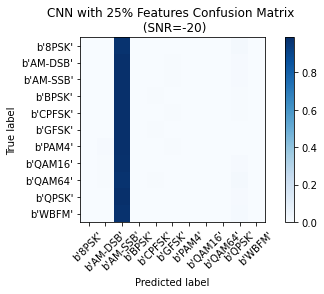

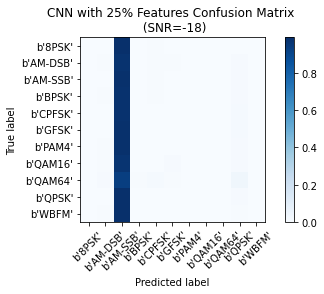

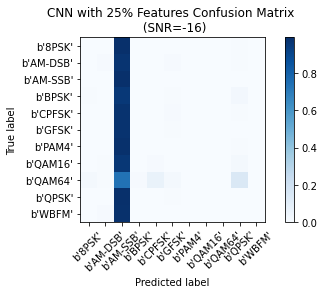

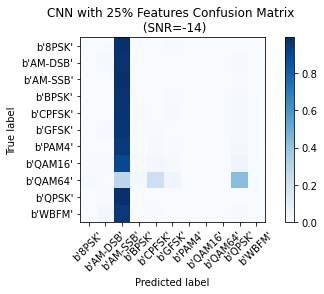

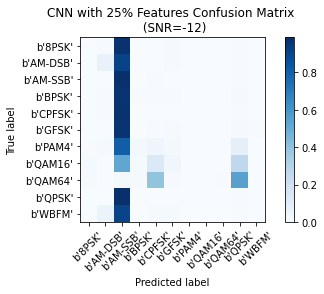

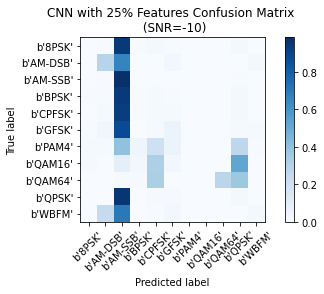

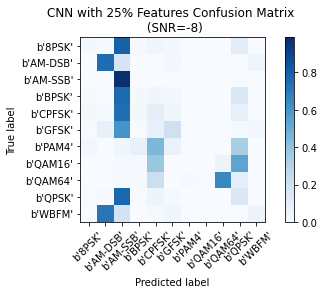

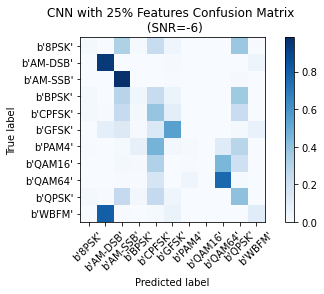

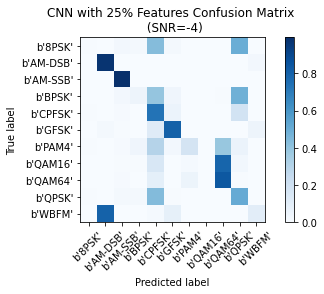

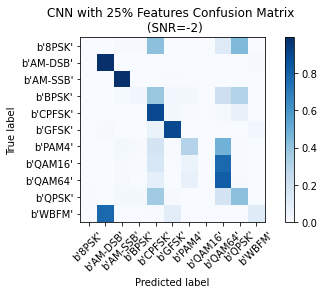

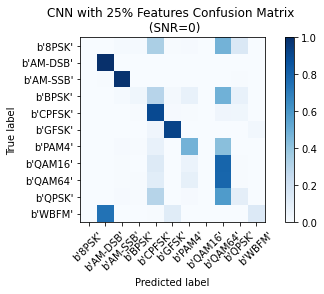

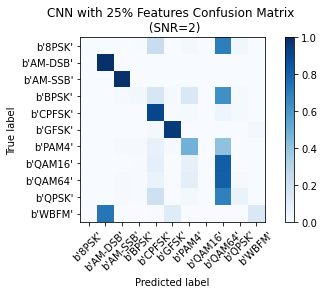

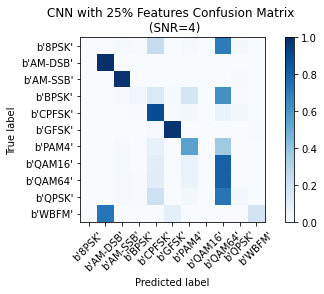

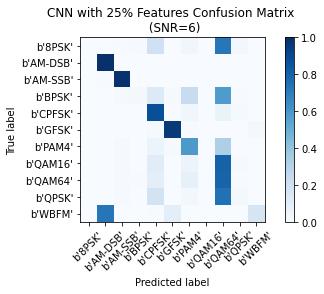

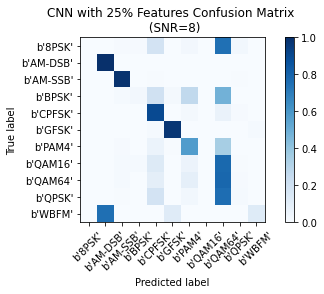

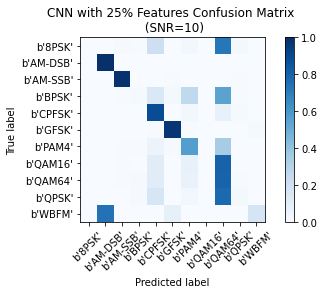

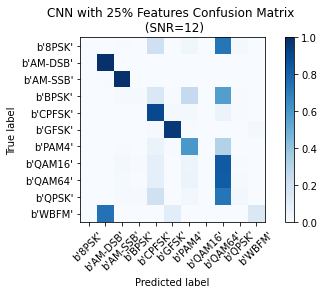

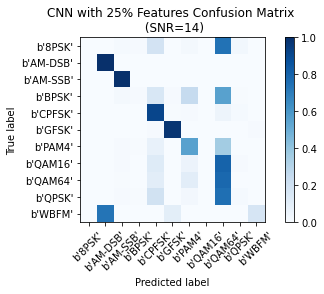

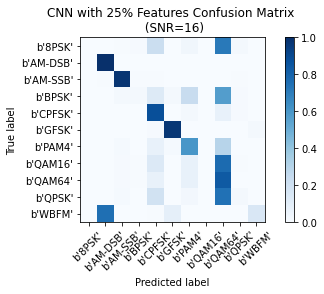

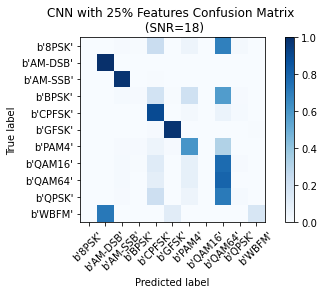

In [104]:
print('Confusion matrix of CNN with 25%% features for different SNRs')
acc_1 = getTestAccArray(model_1, lbl, X_test_1, y_test, test_idx, 'CNN with 25% Features')

Confusion matrix of CNN with 37.5%% features for different SNRs
Overall Accuracy:  0.0923132183908046 for SNR b'-20'
Overall Accuracy:  0.09290016426355174 for SNR b'-18'
Overall Accuracy:  0.09322033898305085 for SNR b'-16'
Overall Accuracy:  0.09326993416239941 for SNR b'-14'
Overall Accuracy:  0.10437890974084003 for SNR b'-12'
Overall Accuracy:  0.16626816258966343 for SNR b'-10'
Overall Accuracy:  0.2655325443786982 for SNR b'-8'
Overall Accuracy:  0.3767586332906998 for SNR b'-6'
Overall Accuracy:  0.45679455001792757 for SNR b'-4'
Overall Accuracy:  0.5357661583151779 for SNR b'-2'
Overall Accuracy:  0.5665196618890114 for SNR b'0'
Overall Accuracy:  0.5656748911465893 for SNR b'2'
Overall Accuracy:  0.5520585544373284 for SNR b'4'
Overall Accuracy:  0.5507246376811594 for SNR b'6'
Overall Accuracy:  0.5489032722042431 for SNR b'8'
Overall Accuracy:  0.5438690158391173 for SNR b'10'
Overall Accuracy:  0.5457855452393956 for SNR b'12'
Overall Accuracy:  0.553958143767061 for SNR 

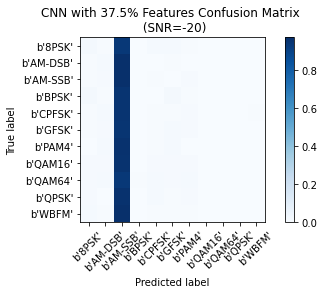

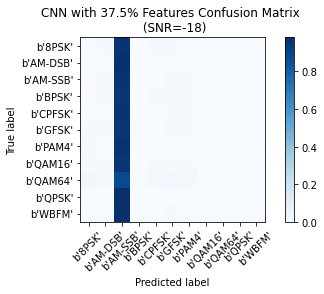

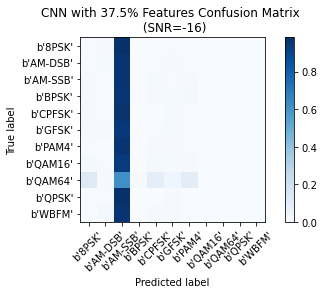

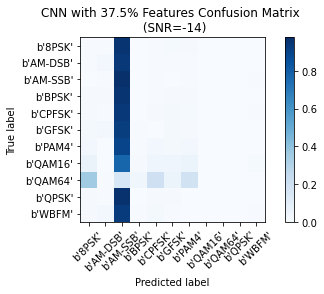

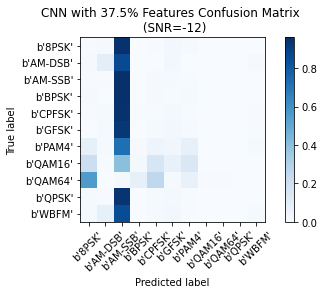

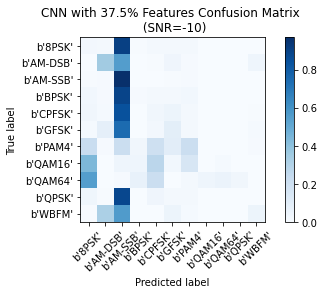

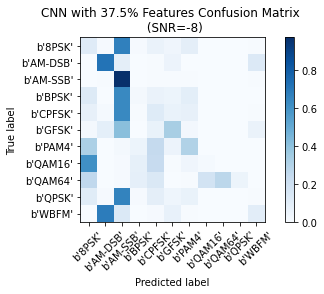

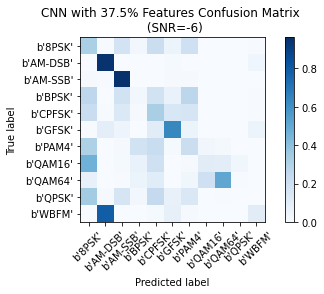

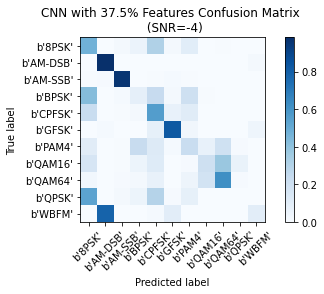

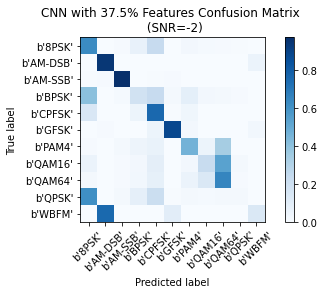

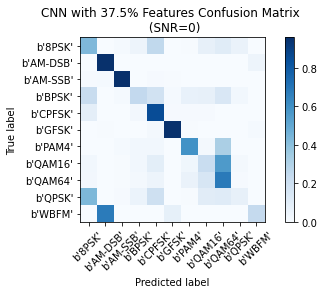

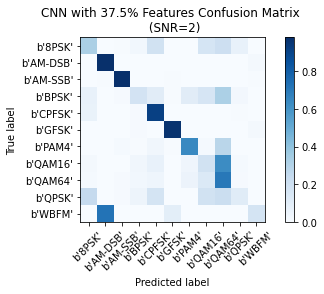

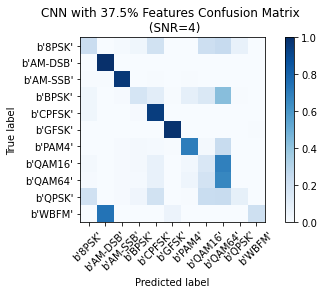

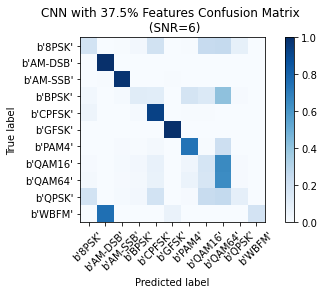

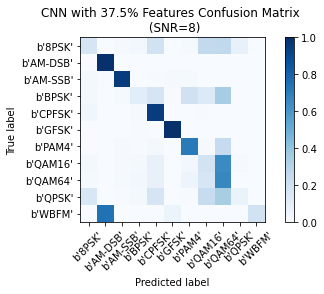

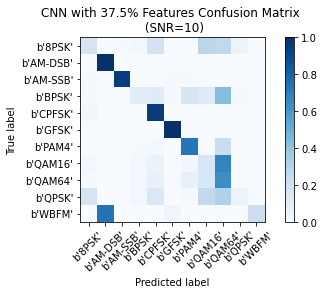

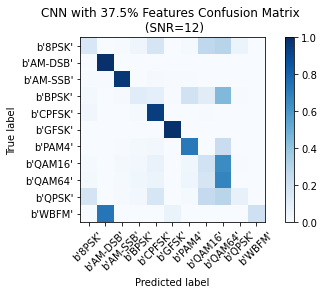

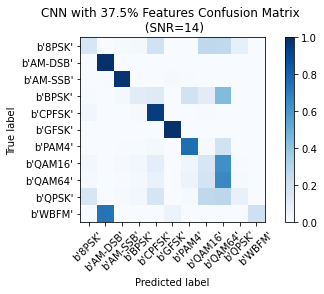

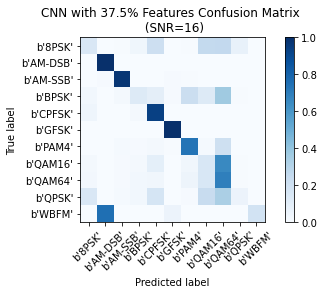

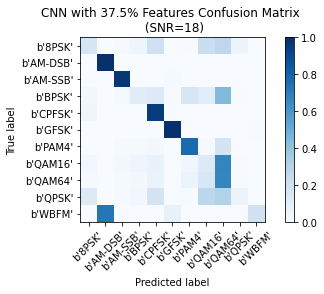

In [105]:
print('Confusion matrix of CNN with 37.5%% features for different SNRs')
acc_2 = getTestAccArray(model_2, lbl, X_test_2, y_test, test_idx, 'CNN with 37.5% Features')

Confusion matrix of CNN with 50%% features for different SNRs
Overall Accuracy:  0.09141522988505747 for SNR b'-20'
Overall Accuracy:  0.09381273955101296 for SNR b'-18'
Overall Accuracy:  0.09448250991705734 for SNR b'-16'
Overall Accuracy:  0.09125822970007315 for SNR b'-14'
Overall Accuracy:  0.10062555853440572 for SNR b'-12'
Overall Accuracy:  0.15872723928637117 for SNR b'-10'
Overall Accuracy:  0.270155325443787 for SNR b'-8'
Overall Accuracy:  0.3869906815274986 for SNR b'-6'
Overall Accuracy:  0.4786661885980638 for SNR b'-4'
Overall Accuracy:  0.5497458242556281 for SNR b'-2'
Overall Accuracy:  0.5826901874310915 for SNR b'0'
Overall Accuracy:  0.5859941944847605 for SNR b'2'
Overall Accuracy:  0.5802378774016469 for SNR b'4'
Overall Accuracy:  0.5787928820399927 for SNR b'6'
Overall Accuracy:  0.5719165767709457 for SNR b'8'
Overall Accuracy:  0.5760811532301121 for SNR b'10'
Overall Accuracy:  0.5652648825778264 for SNR b'12'
Overall Accuracy:  0.5747042766151046 for SNR b'

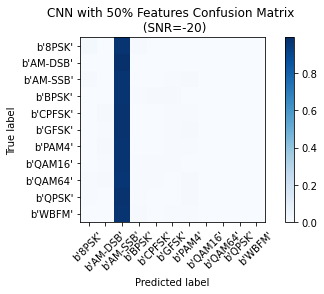

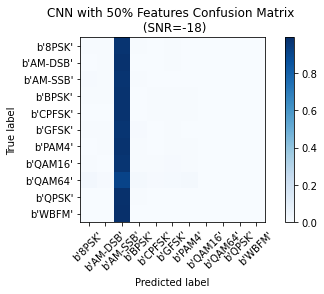

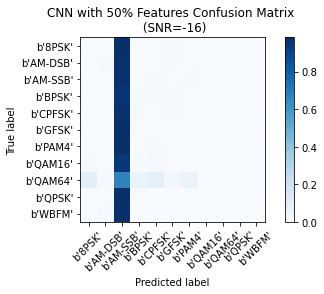

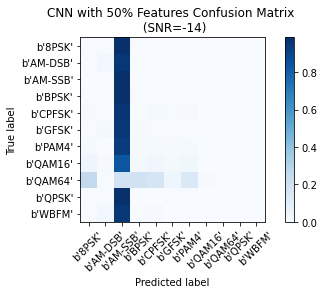

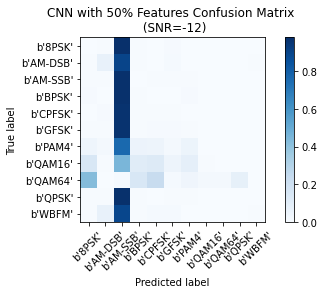

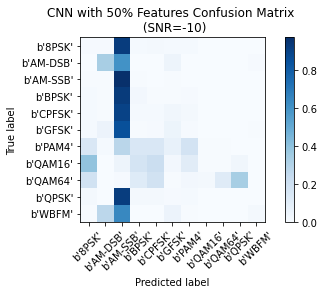

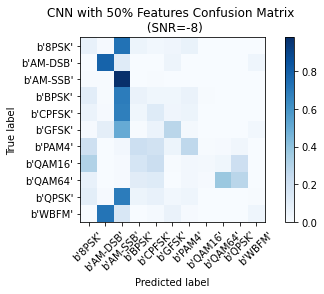

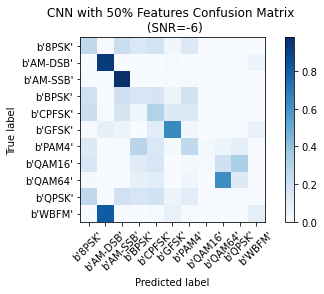

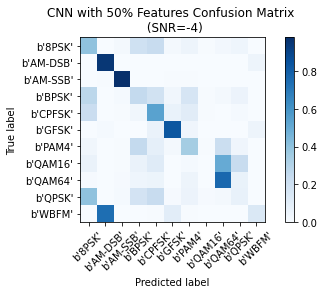

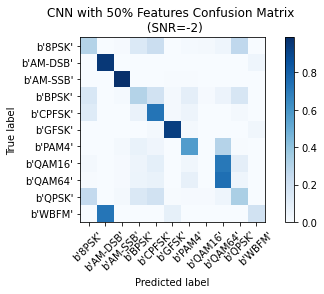

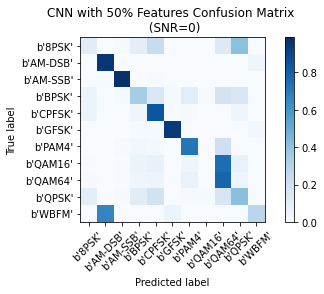

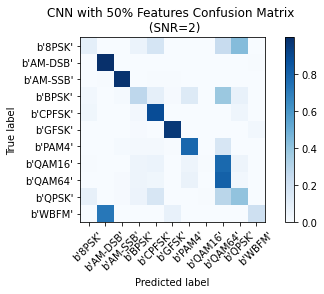

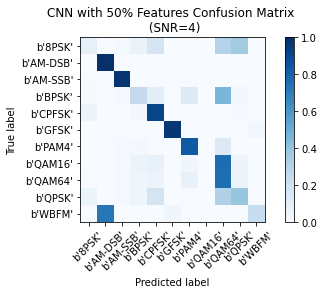

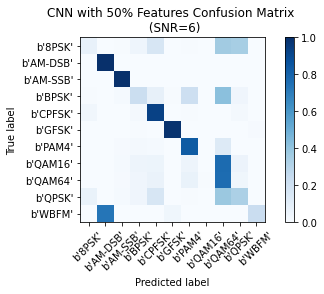

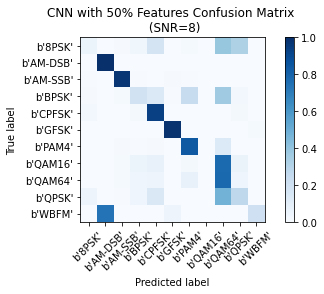

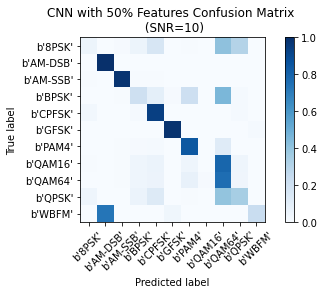

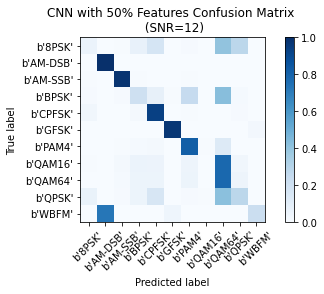

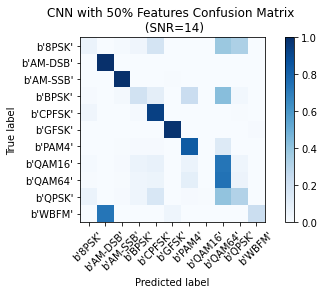

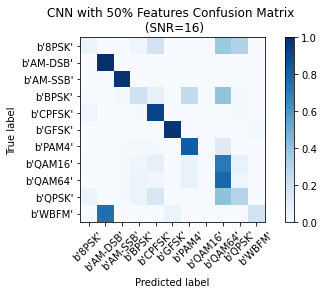

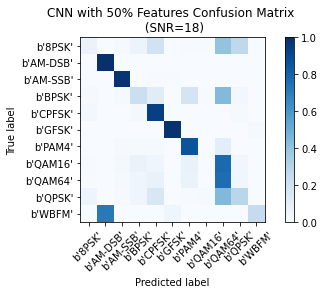

In [106]:
print('Confusion matrix of CNN with 50%% features for different SNRs')
acc_3 = getTestAccArray(model_3, lbl, X_test_3, y_test, test_idx, 'CNN with 50% Features')

Confusion matrix of CNN with 75%% features for different SNRs
Overall Accuracy:  0.09177442528735633 for SNR b'-20'
Overall Accuracy:  0.09545537506844315 for SNR b'-18'
Overall Accuracy:  0.09448250991705734 for SNR b'-16'
Overall Accuracy:  0.08997805413313825 for SNR b'-14'
Overall Accuracy:  0.10134048257372655 for SNR b'-12'
Overall Accuracy:  0.16369321316902705 for SNR b'-10'
Overall Accuracy:  0.26960059171597633 for SNR b'-8'
Overall Accuracy:  0.3864425360862416 for SNR b'-6'
Overall Accuracy:  0.4659376120473288 for SNR b'-4'
Overall Accuracy:  0.5076252723311547 for SNR b'-2'
Overall Accuracy:  0.5411613377434766 for SNR b'0'
Overall Accuracy:  0.5607764876632801 for SNR b'2'
Overall Accuracy:  0.568892955169259 for SNR b'4'
Overall Accuracy:  0.564483580994313 for SNR b'6'
Overall Accuracy:  0.5555555555555556 for SNR b'8'
Overall Accuracy:  0.5684285460046271 for SNR b'10'
Overall Accuracy:  0.556344438376115 for SNR b'12'
Overall Accuracy:  0.5739763421292083 for SNR b'1

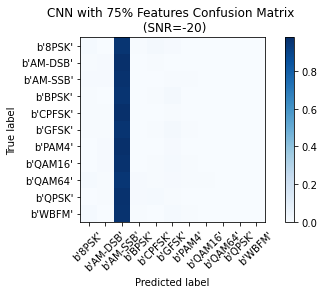

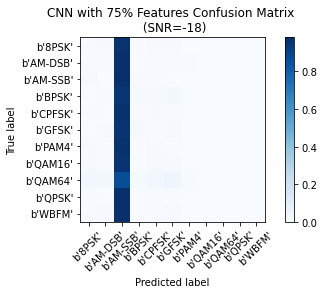

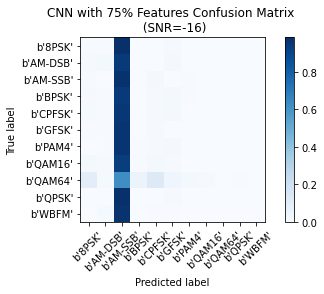

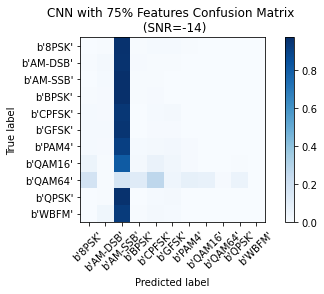

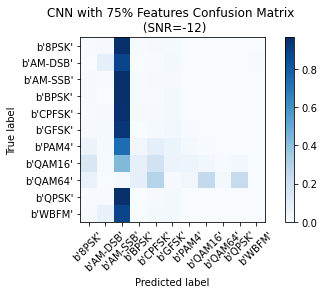

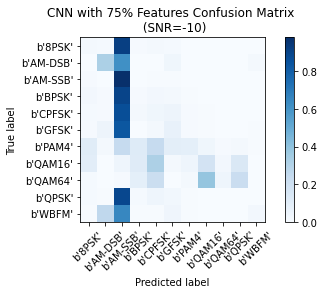

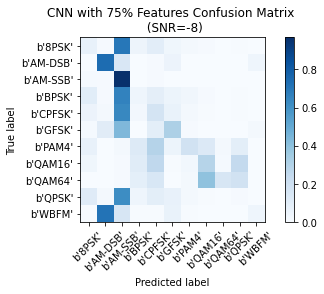

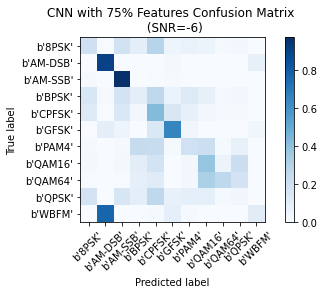

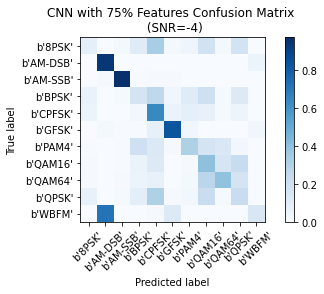

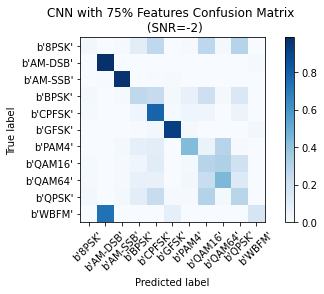

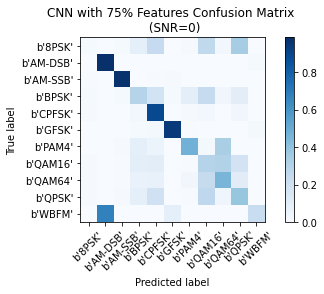

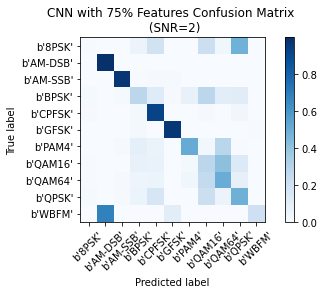

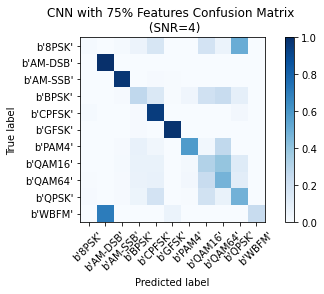

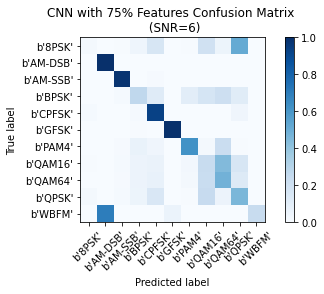

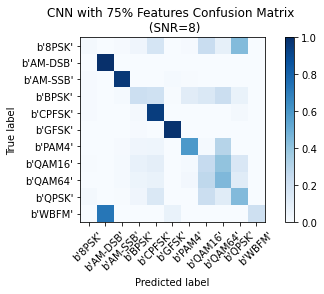

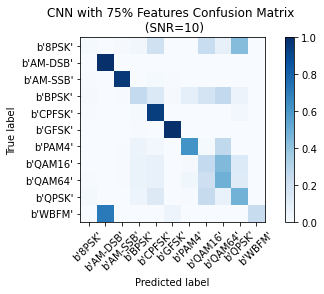

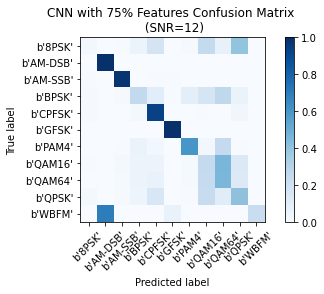

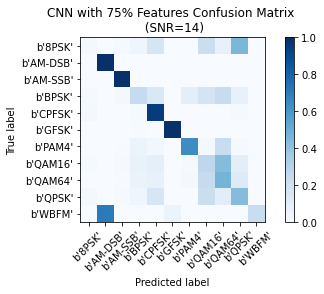

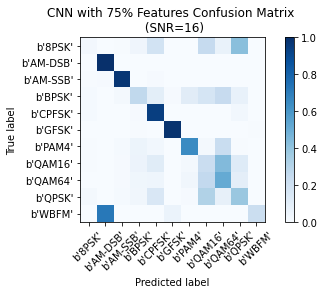

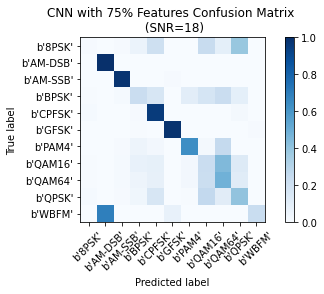

In [107]:
print('Confusion matrix of CNN with 75%% features for different SNRs')
acc_4 = getTestAccArray(model_4, lbl, X_test_4, y_test, test_idx, 'CNN with 75% Features')

Confusion matrix of CNN with all features for different SNRs
Overall Accuracy:  0.09123563218390805 for SNR b'-20'
Overall Accuracy:  0.09545537506844315 for SNR b'-18'
Overall Accuracy:  0.0998918139199423 for SNR b'-16'
Overall Accuracy:  0.10698610095098757 for SNR b'-14'
Overall Accuracy:  0.14119749776586238 for SNR b'-12'
Overall Accuracy:  0.2192385506713261 for SNR b'-10'
Overall Accuracy:  0.34356508875739644 for SNR b'-8'
Overall Accuracy:  0.4966197697789147 for SNR b'-6'
Overall Accuracy:  0.6276443169594836 for SNR b'-4'
Overall Accuracy:  0.7273057371096586 for SNR b'-2'
Overall Accuracy:  0.8061374494671076 for SNR b'0'
Overall Accuracy:  0.8194847605224964 for SNR b'2'
Overall Accuracy:  0.8128087831655992 for SNR b'4'
Overall Accuracy:  0.822968262704091 for SNR b'6'
Overall Accuracy:  0.8106796116504854 for SNR b'8'
Overall Accuracy:  0.816337426588361 for SNR b'10'
Overall Accuracy:  0.8117604223557254 for SNR b'12'
Overall Accuracy:  0.8151046405823476 for SNR b'14'

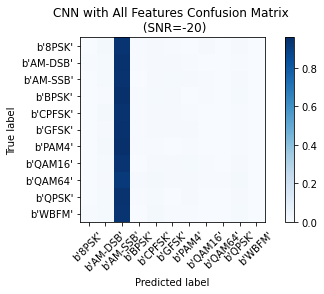

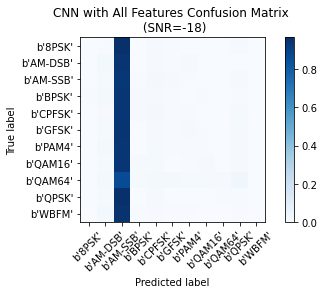

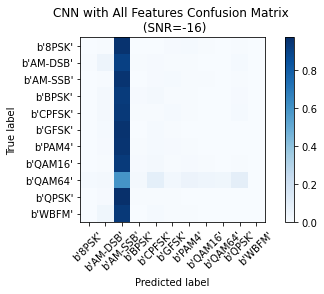

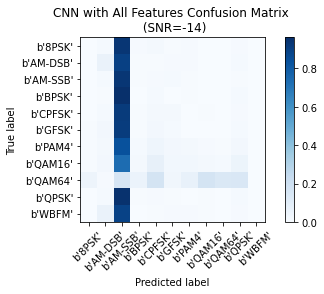

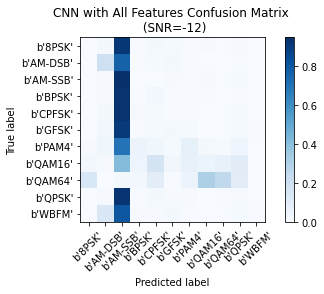

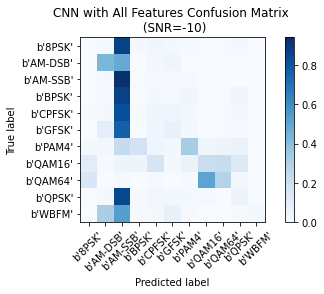

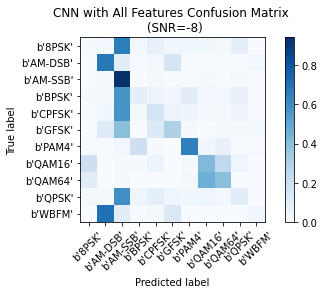

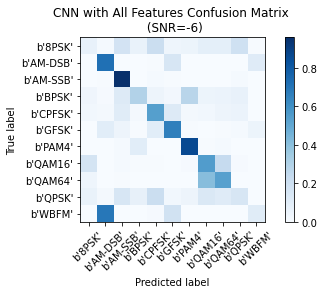

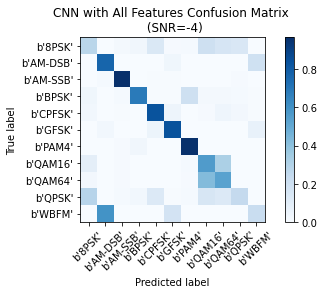

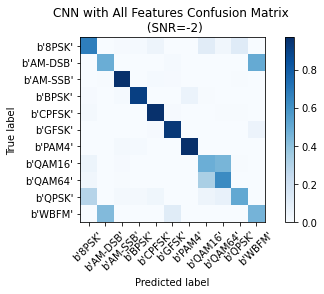

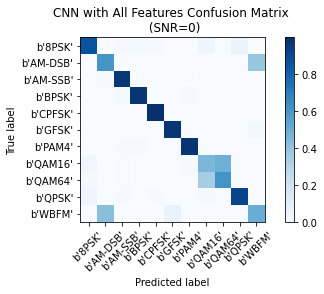

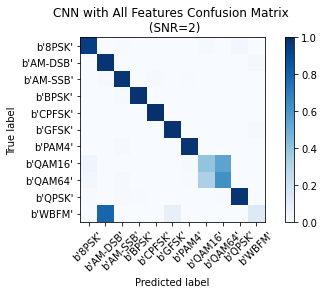

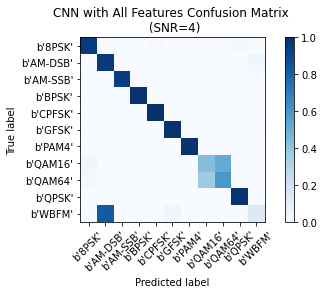

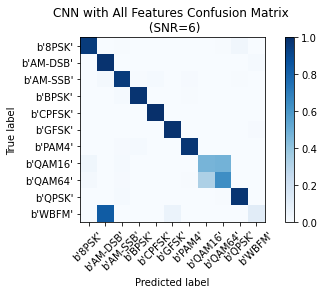

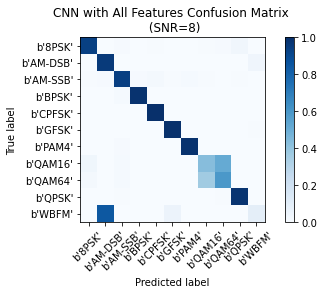

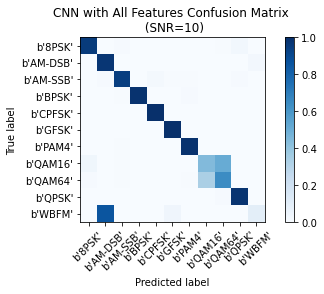

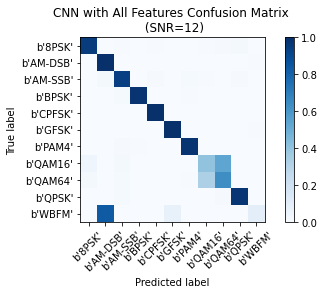

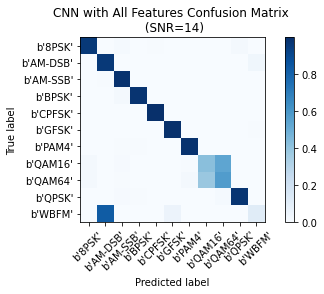

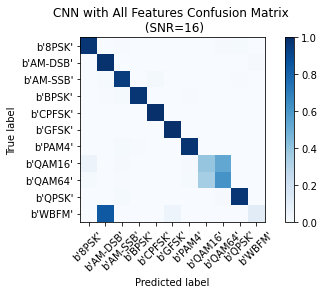

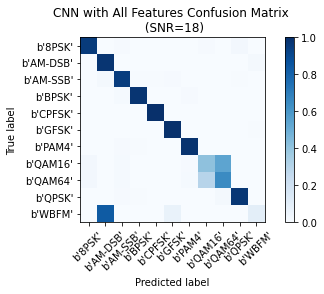

In [108]:
print('Confusion matrix of CNN with all features for different SNRs')
acc_5 = getTestAccArray(model_5, lbl, X_test, y_test, test_idx, 'CNN with All Features')

## Plot accuracy curves

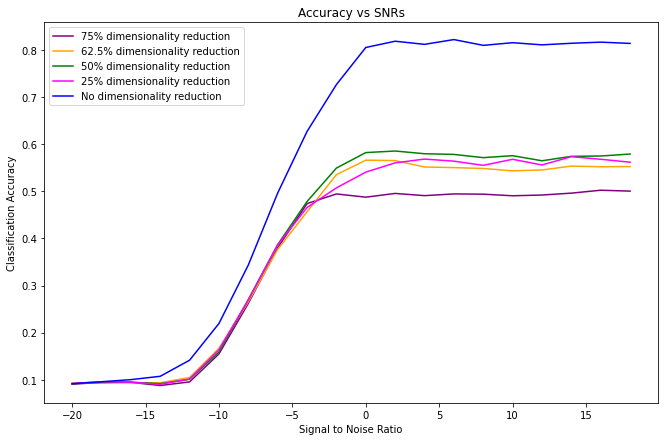

In [109]:
plt.figure(figsize = (11, 7))
plt.plot(snrs, acc_1, color= 'purple', label= '75% dimensionality reduction')
plt.plot(snrs, acc_2, color= 'orange', label= '62.5% dimensionality reduction')
plt.plot(snrs, acc_3, color= 'green', label= '50% dimensionality reduction')
plt.plot(snrs, acc_4, color= 'magenta', label= '25% dimensionality reduction')
plt.plot(snrs, acc_5, color= 'blue', label= 'No dimensionality reduction')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title('Accuracy vs SNRs')
plt.legend()
plt.savefig('img/CNN_using_PCA_result.png')
plt.show()